In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import sys
sys.path.append('../scripts')
from paths import SIMULATED_PATH
from models import NaiveModel
from simulated_data import NaiveDataGenerator, NaiveCrowdsourcingDataGenerator, ACTIONS
from experiments import PretrainedProbe
from omegaconf import OmegaConf
from sklearn.metrics import average_precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
import itertools
from textwrap import wrap

C:\Users\dylan\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dylan\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\dylan\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
cfg = OmegaConf.load(f'{SIMULATED_PATH}/outputs/naive_batch-size-1024/.hydra/config.yaml')
cfg.model.batch_size = 16
cfg

{'model': {'name': 'naive', 'hidden_width': 128, 'discount_factor': 0.85, 'input_width': 90, 'output_width': 60, 'sampling_rate': 1, 'stride': 30, 'batch_size': 16}, 'patience': 5}

In [3]:
gen = NaiveCrowdsourcingDataGenerator(cfg)

In [4]:
x = []
y = []
for batch_x, batch_y in gen.train:
    x.append(batch_x.numpy())
    y.append(batch_y.numpy())
x = np.concatenate(x)
y = np.concatenate(y)
y_split = np.split(y, indices_or_sections=y.shape[1], axis=1)
dummy_classifiers = [DummyClassifier(strategy='stratified') for _ in range(len(y_split))]
for i in range(len(y_split)):
    y = y_split[i][:,0]
    x_i = x[y >= 0]
    y = y[y >= 0]
    dummy_classifiers[i].fit(x_i, y)

class DummyModel:
    def __init__(self, dummy_classifiers):
        self.dummy_classifiers = dummy_classifiers
    
    def __call__(self, x):
        y = []
        for i, classifier in enumerate(self.dummy_classifiers):
            y.append(classifier.predict(x[:,i]))
        return tf.convert_to_tensor(np.stack(y, axis=1), dtype=tf.float32)
    
dummy_model = DummyModel(dummy_classifiers)

In [5]:
direct_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(ACTIONS), activation='sigmoid')
])
direct_model(next(iter(gen.train))[0])
direct_model.load_weights(f'{SIMULATED_PATH}/outputs/direct.h5')

In [6]:
supervised_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(cfg.model.hidden_width, activation='relu'),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(len(ACTIONS), activation='sigmoid')
])
supervised_model(next(iter(gen.train))[0])
supervised_model.load_weights(f'{SIMULATED_PATH}/outputs/supervised.h5')

In [7]:
model = NaiveModel(cfg)
model_gen = NaiveDataGenerator(cfg)
model(next(iter(model_gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/naive_batch-size-1024/weights.h5')
pretrained_probe = PretrainedProbe(cfg, model)
pretrained_probe(next(iter(gen.train))[0])
pretrained_probe.load_weights(f'{SIMULATED_PATH}/outputs/pretrained_probe.h5')

In [8]:
model = NaiveModel(cfg)
model_gen = NaiveDataGenerator(cfg)
model(next(iter(model_gen.train))[0])
model.load_weights(f'{SIMULATED_PATH}/outputs/naive_batch-size-1024/weights.h5')
finetune_probe = PretrainedProbe(cfg, model)
finetune_probe(next(iter(gen.train))[0])
finetune_probe.load_weights(f'{SIMULATED_PATH}/outputs/pretrained_finetuning.h5')

In [9]:
true_labels = {k: [] for k in ACTIONS}
dummy_model_predictions = {k: [] for k in ACTIONS}
direct_model_predictions = {k: [] for k in ACTIONS}
supervised_predictions = {k: [] for k in ACTIONS}
pretrained_model_predictions = {k: [] for k in ACTIONS}
finetune_predictions = {k: [] for k in ACTIONS}
for x_batch, y_batch in gen.test:
    y_batch = y_batch.numpy()
    dummy_pred = dummy_model(x_batch).numpy()
    direct_pred = direct_model(x_batch).numpy()
    supervised_pred = supervised_model(x_batch).numpy()
    pretrained_probe_pred = pretrained_probe(x_batch).numpy()
    finetune_pred = finetune_probe(x_batch).numpy()
    for y, y_dummy, y_direct, y_linear, y_pretrained, y_finetuned in zip(y_batch, dummy_pred, direct_pred, supervised_pred, pretrained_probe_pred, finetune_pred):
        for i, action in enumerate(ACTIONS):
            if y[i] == -1:
                continue
            true_labels[action].append(y[i])
            dummy_model_predictions[action].append(y_dummy[i])
            direct_model_predictions[action].append(y_direct[i])
            supervised_predictions[action].append(y_linear[i])
            pretrained_model_predictions[action].append(y_pretrained[i])
            finetune_predictions[action].append(y_finetuned[i])
for labels in [true_labels, dummy_model_predictions, direct_model_predictions, supervised_predictions, pretrained_model_predictions, finetune_predictions]:
    labels = {k: np.array(v) for k, v in labels.items()}

In [10]:
df = []
for action in ACTIONS:
    for model, predictions in zip(['random stratified', 'perceptron', 'fully supervised', 'pretrained + probe', 'pretrained + finetuning'], 
                                  [dummy_model_predictions, direct_model_predictions, supervised_predictions, pretrained_model_predictions, finetune_predictions]):
        df.append({
            'action': action,
            'model': model,
            'average precision': average_precision_score(true_labels[action], predictions[action])
        })
df = pd.DataFrame(df)
df

,action,model,average precision
0,hit,random stratified,0.875545
1,hit,perceptron,0.845227
2,hit,fully supervised,0.960123
3,hit,pretrained + probe,0.932741
4,hit,pretrained + finetuning,0.950017
...,...,...,...
115,tumble,random stratified,0.368573
116,tumble,perceptron,0.614071
117,tumble,fully supervised,0.676737
118,tumble,pretrained + probe,0.632262


In [12]:
responses = pd.read_csv(f'{SIMULATED_PATH}/crowdsourcing/production_1/responses.csv', index_col='index')
agreement = responses.groupby('action')['agreement'].mean().sort_values(ascending=False).reset_index()
agreement['model'] = 'annotation agreement'
action_idx = {x: i for i, x in enumerate(agreement['action'].values)}
agreement = agreement.rename(columns={'agreement': 'average precision'})
merged = pd.concat([df, agreement])
model_indices = {x: i for i, x in enumerate(['random stratified', 'perceptron', 'fully supervised', 'pretrained + probe', 'pretrained + finetuning', 'annotation agreement'])}
merged['model_idx'] = merged.apply(lambda row: model_indices[row['model']], axis=1)
merged['action_idx'] = merged.apply(lambda row: action_idx[row['action']], axis=1)
merged = merged.sort_values(by=['action_idx', 'model_idx']).drop(['action_idx', 'model_idx'], axis=1)
merged

,action,model,average precision
35,fall,random stratified,0.257319
36,fall,perceptron,0.905069
37,fall,fully supervised,0.944509
38,fall,pretrained + probe,0.928747
39,fall,pretrained + finetuning,0.928873
...,...,...,...
16,turn,perceptron,0.685895
17,turn,fully supervised,0.664965
18,turn,pretrained + probe,0.820716
19,turn,pretrained + finetuning,0.823510


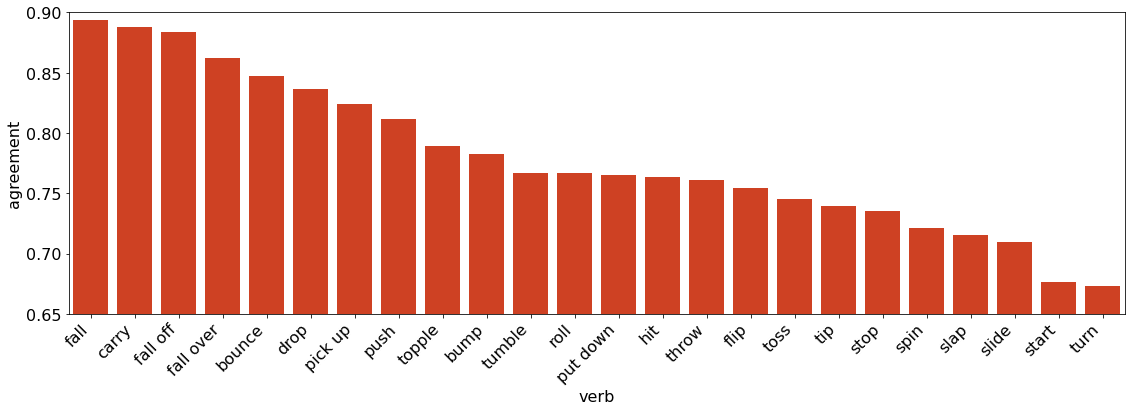

In [12]:
agreement = agreement.rename(columns={'average precision': 'agreement', 'action': 'verb'})

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(16, 6))
plt.xticks(rotation=45, ha='right')
ax = sns.barplot(data=agreement, x='verb', y='agreement', color='#eb2f06')
ax.set_ylim([.65, .9])

plt.tight_layout()
plt.savefig(f'{SIMULATED_PATH}/docs/agreement.png', dpi=300)

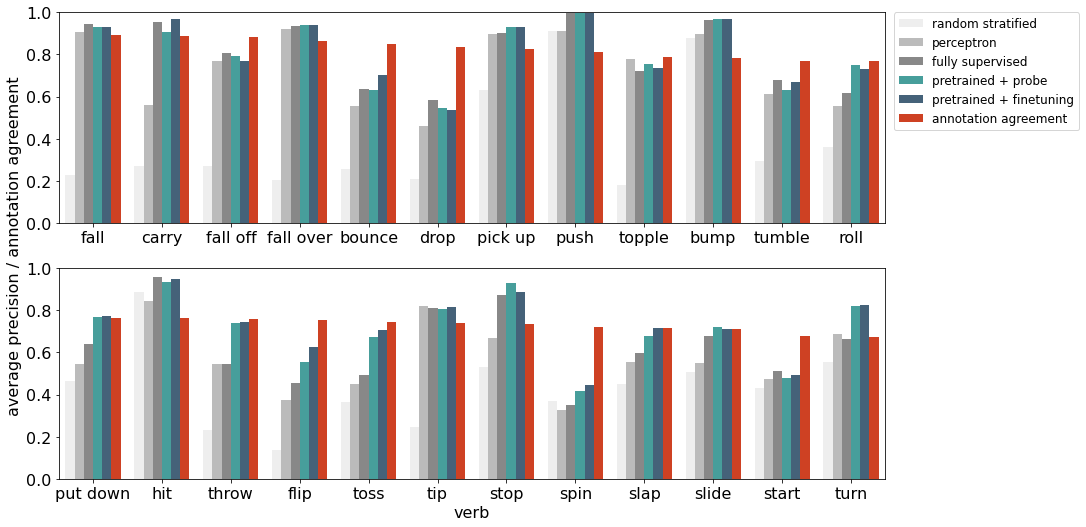

In [13]:
actions = merged['action'].unique()

plt.rcParams['font.size'] = '16'
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
palette = sns.color_palette(n_colors=6)
palette[0] = '#eeeeee'
palette[1] = '#bbbbbb'
palette[2] = '#888888'
palette[3] = '#38ada9' 
palette[4] = '#3c6382'
palette[5] = '#eb2f06'

data_1 = merged[merged['action'].isin(actions[:len(actions) // 2])]
g = sns.barplot(data=data_1, x='action', y='average precision', hue='model', palette=palette, ax=ax1)
ax1.set_ylim([0, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
leg = ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 12})

data_2 = merged[merged['action'].isin(actions[len(actions) // 2:])]
g = sns.barplot(data=data_2, x='action', y='average precision', hue='model', palette=palette, ax=ax2)
ax2.set_ylim([0, 1])
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.get_legend().remove()

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_ylabel('average precision / annotation agreement')
ax.set_xlabel('verb')

plt.tight_layout()
plt.savefig(f'{SIMULATED_PATH}/docs/results.png', dpi=300)

In [13]:
df.groupby('model').mean().sort_values(by='average precision')

,average precision
model,
random stratified,0.411876
perceptron,0.652867
fully supervised,0.721822
pretrained + probe,0.762797
pretrained + finetuning,0.773878


In [14]:
responses = pd.read_csv(f'{SIMULATED_PATH}/crowdsourcing/production_1/responses.csv', index_col='index')
actions = responses['action'].unique().tolist()
heatmap = []
for action, group in responses[responses['mode'] == 'yes'].groupby('action'):
    for other in actions:
        overlap = responses[(responses['action'] == other) & (responses['url'].isin(group['url'].tolist()))]
        match = len(overlap[overlap['mode'] == 'yes']) / len(overlap)
        heatmap.append({
            'clips labeled': action,
            'proportion also labeled': other,
            'match': match
        })
heatmap = pd.DataFrame(heatmap)
heatmap = heatmap.pivot('clips labeled', 'proportion also labeled', 'match')
print(heatmap.mean().mean())

0.48466790635886786


In [16]:
'''categories = [
    ['roll', 'slide'],
    ['throw', 'toss'],
    ['fall', 'drop', 'bounce', 'fall off'],
    ['spin', 'tip', 'topple', 'tumble', 'turn', 'roll', 'fall over'],
    ['pick up', 'put down'],
    ['hit', 'push', 'slap', 'bump']
]'''
categories = [
    ['toss', 'throw']
]
rows = []
for category in categories:
    for pair in itertools.combinations(category, 2):
        a, b = pair
        ab = heatmap[b][a]
        ba = heatmap[a][b]
        rows.append({
            'a': a,
            'b': b,
            'ab': ab,
            'ba': ba,
            'mean': (ab+ba) / 2,
            'difference': np.abs(ab-ba)
        })
coocc = pd.DataFrame(rows).sort_values(by='mean')
coocc

,a,b,ab,ba,mean,difference
0,toss,throw,0.667897,0.747934,0.707915,0.080037
